<a href="https://colab.research.google.com/github/Manasa-Raghavendra/Internship_tasks/blob/main/cGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Step 1 — environment check (run this first)
!nvidia-smi

# Install TF Datasets helper (if not already installed)
!pip install -q tensorflow-datasets

import tensorflow as tf
import tensorflow_datasets as tfds

print("TensorFlow version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))


Sun Sep 14 16:05:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [14]:
# Download and extract the maps dataset
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
!tar -xvzf maps.tar.gz




--2025-09-14 16:05:52--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: ‘maps.tar.gz’

maps.tar.gz         100%[===================>] 238.65M   585KB/s    in 8m 29s  

2025-09-14 16:14:22 (480 KB/s) - ‘maps.tar.gz’ saved [250242400/250242400]

maps/
maps/train/
maps/train/1.jpg
maps/train/10.jpg
maps/train/100.jpg
maps/train/1000.jpg
maps/train/1001.jpg
maps/train/1002.jpg
maps/train/1003.jpg
maps/train/1004.jpg
maps/train/1005.jpg
maps/train/1006.jpg
maps/train/1007.jpg
maps/train/1008.jpg
maps/train/1009.jpg
maps/train/101.jpg
maps/train/1010.jpg
maps/train/1011.jpg
maps/train/1012.jpg
maps/train/1013.jpg
maps/train/1014.jpg
maps/train/1015.jpg
maps/train/530.jpg
maps/train/531

In [15]:
import tensorflow as tf
import os
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to train and test
train_path = "maps/train/"
val_path = "maps/val/"

# Function to load & split image into input/target
def load_image(image_file):
    # Load and decode
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    # Split into input (aerial) and real (map)
    w = tf.shape(image)[1] // 2
    input_image = image[:, :w, :]
    real_image = image[:, w:, :]

    input_image = tf.image.resize(input_image, [256, 256])
    real_image = tf.image.resize(real_image, [256, 256])

    input_image = (tf.cast(input_image, tf.float32) / 127.5) - 1
    real_image = (tf.cast(real_image, tf.float32) / 127.5) - 1

    return input_image, real_image

# Create tf.data pipelines
train_dataset = tf.data.Dataset.list_files(train_path + "*.jpg")
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(1)

val_dataset = tf.data.Dataset.list_files(val_path + "*.jpg")
val_dataset = val_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(1)


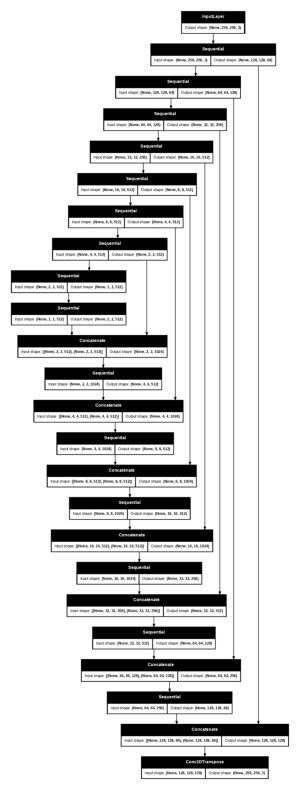

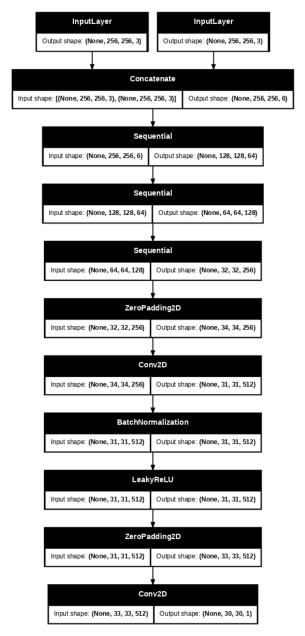

In [16]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# ------------------------
# Downsample block
# ------------------------
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

# ------------------------
# Upsample block
# ------------------------
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

# ------------------------
# Generator (U-Net)
# ------------------------
def Generator():
    inputs = layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (128x128x64)
        downsample(128, 4),  # (64x64x128)
        downsample(256, 4),  # (32x32x256)
        downsample(512, 4),  # (16x16x512)
        downsample(512, 4),  # (8x8x512)
        downsample(512, 4),  # (4x4x512)
        downsample(512, 4),  # (2x2x512)
        downsample(512, 4),  # (1x1x512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (2x2x1024)
        upsample(512, 4, apply_dropout=True),  # (4x4x1024)
        upsample(512, 4, apply_dropout=True),  # (8x8x1024)
        upsample(512, 4),  # (16x16x1024)
        upsample(256, 4),  # (32x32x512)
        upsample(128, 4),  # (64x64x256)
        upsample(64, 4),   # (128x128x128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')  # (256x256x3)

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x, name="Generator")

# ------------------------
# Discriminator (PatchGAN)
# ------------------------
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    tar = layers.Input(shape=[256, 256, 3], name='target_image')

    x = layers.Concatenate()([inp, tar])  # channel concat

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)
    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=[inp, tar], outputs=last, name="Discriminator")

# ------------------------
# Build models
# ------------------------
generator = Generator()
discriminator = Discriminator()

# ------------------------
# Save and Display plots
# ------------------------
plot_model(generator, show_shapes=True, dpi=64, to_file="generator.png")
plot_model(discriminator, show_shapes=True, dpi=64, to_file="discriminator.png")

# Display generator
img = mpimg.imread("generator.png")
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis("off")
plt.show()

# Display discriminator
img = mpimg.imread("discriminator.png")
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.axis("off")
plt.show()



In [17]:
# Step 3 — Define Loss Functions

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator Loss
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    fake_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + fake_loss
    return total_disc_loss

# Generator Loss
def generator_loss(disc_generated_output, gen_output, target, LAMBDA=100):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # L1 Loss for similarity
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss


In [18]:
# Step 4 — Define Optimizers

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [19]:
# Step 5 — Define Loss Functions and Training Step

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator loss
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

# Generator loss
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # L1 Loss
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (100 * l1_loss)
    return total_gen_loss


In [20]:
# Step 6 — Training Step Function

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate image
        gen_output = generator(input_image, training=True)

        # Discriminator outputs
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        # Compute losses
        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    # Calculate gradients
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))


In [21]:
import matplotlib.pyplot as plt

# Function to visualize generator predictions
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)

    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Scale back from [-1,1] to [0,1] for display
        plt.imshow((display_list[i] + 1) / 2)
        plt.axis('off')
    plt.show()



Epoch 1


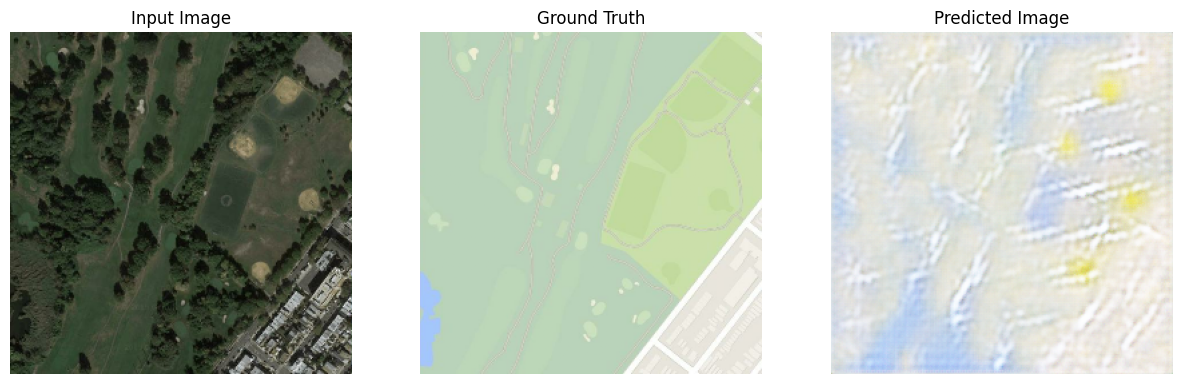


Epoch 2


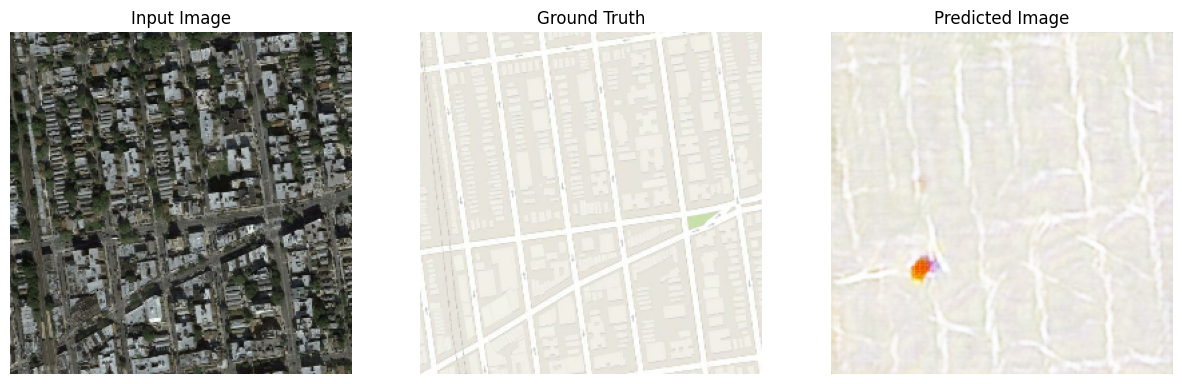


Epoch 3


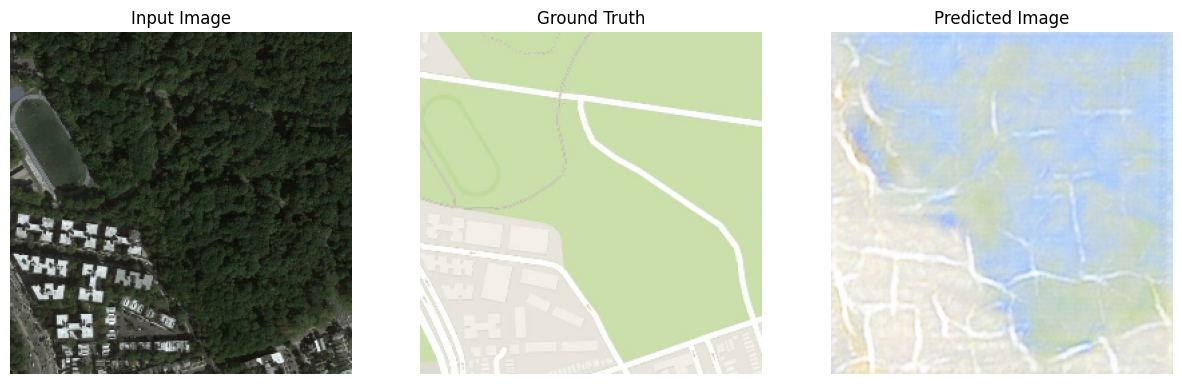


Epoch 4


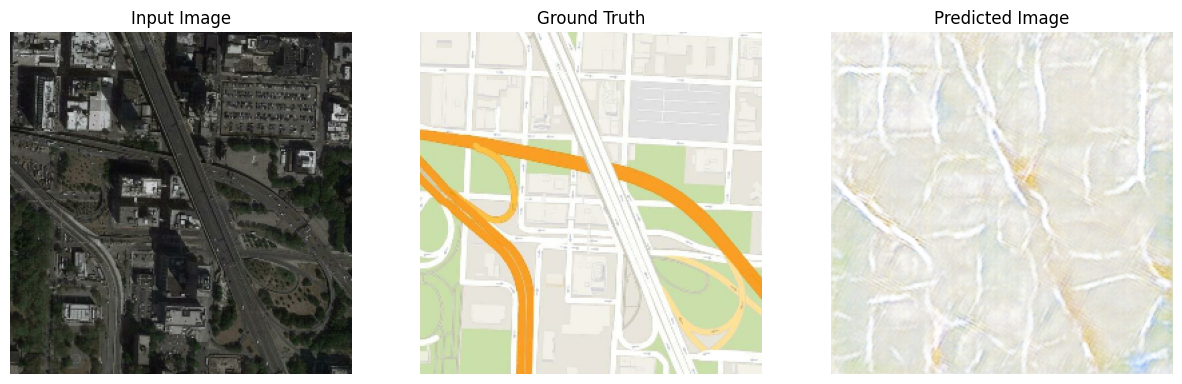


Epoch 5


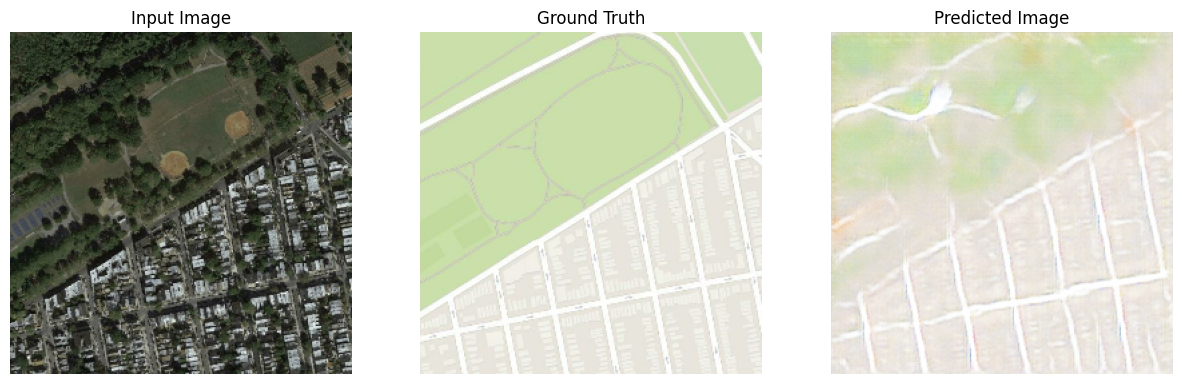

In [22]:
# Step 7 — Training Loop

import datetime

EPOCHS = 5   # you can increase later (e.g., 50, 100 for better results)

def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        print("\nEpoch", epoch+1)

        # Training loop
        for n, (input_image, target) in train_ds.enumerate():
            train_step(input_image, target)

        # Generate sample images after each epoch
        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target)


# Run training
fit(train_dataset, EPOCHS, val_dataset)



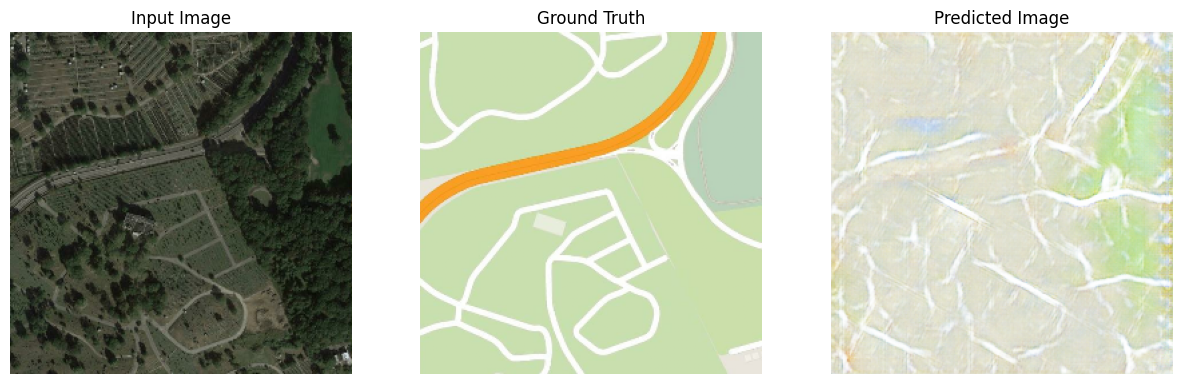

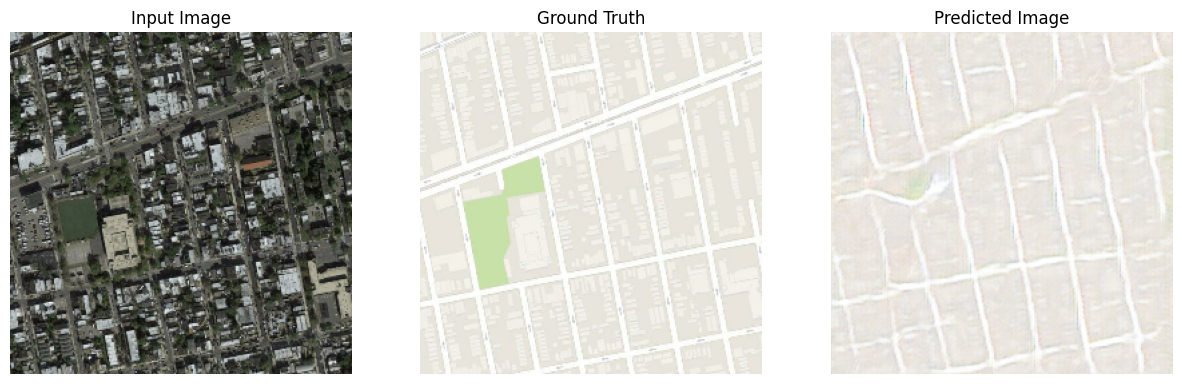

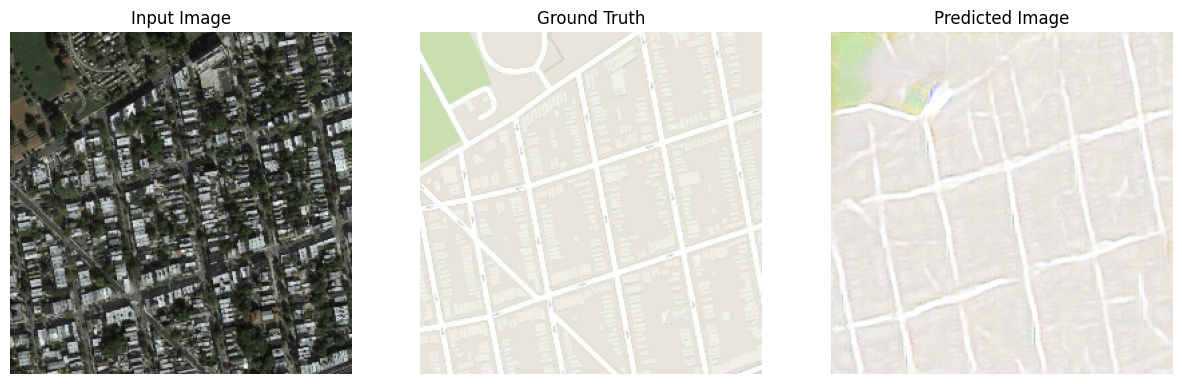

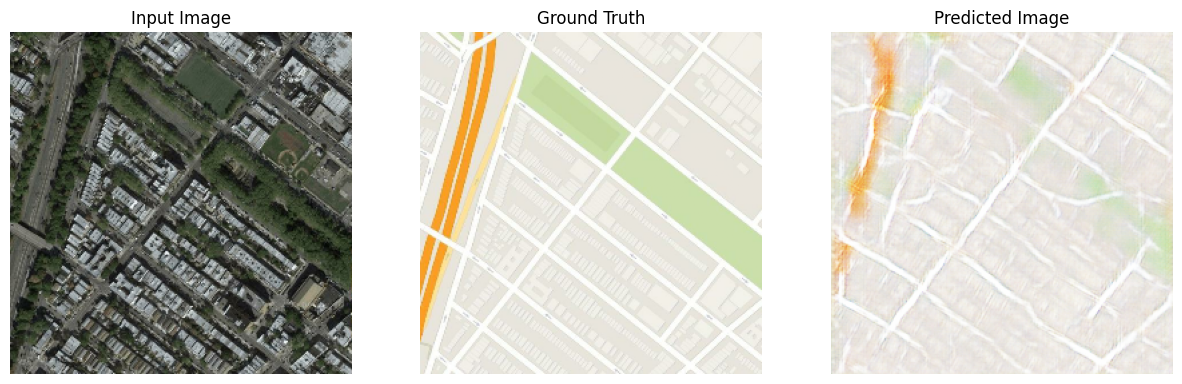

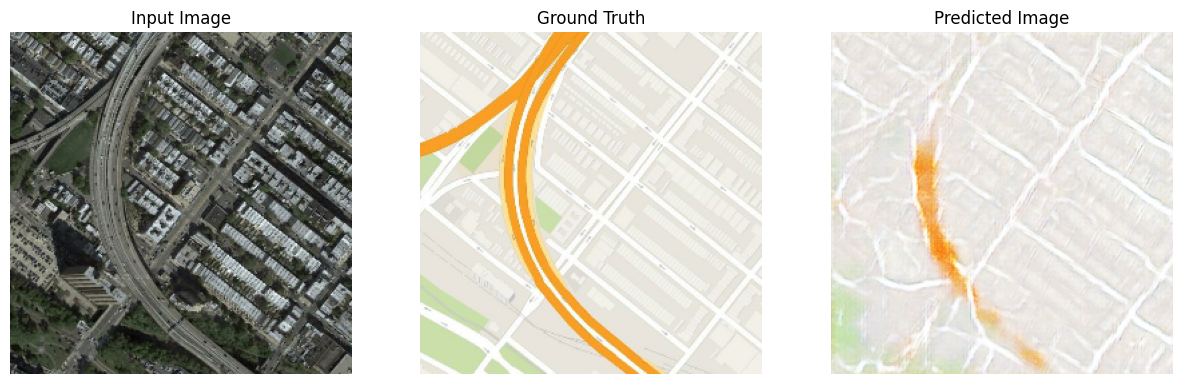

In [23]:
# Evaluate on a few validation samples
for inp, tar in val_dataset.take(5):  # show 5 examples
    generate_images(generator, inp, tar)


In [24]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        print("Epoch", epoch + 1)

        for input_image, target in train_ds:
            train_step(input_image, target)

        # Generate sample images after each epoch
        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target)

        # ✅ Save checkpoint at end of epoch
        checkpoint.save(file_prefix=checkpoint_prefix)


In [25]:
import tensorflow as tf

# Rebuild the generator model
generator = Generator()  # Make sure this is the same function you used to define the model

# Define the optimizer again (same as during training)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Create a checkpoint object
checkpoint_dir = './training_checkpoints'  # same directory where you saved the checkpoints
checkpoint_prefix = checkpoint_dir + "/ckpt"
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 generator=generator)


In [26]:
# Restore the latest checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


In [33]:
from google.colab import files
uploaded = files.upload()


Saving 68c065c8e43b2bcaa9829062.png to 68c065c8e43b2bcaa9829062.png


In [35]:
import os
os.listdir()


['.config',
 'captivating-birdseye-perspective-crossroads-vaihingen-der-enz-germany-revealed-stunning_1000124-105380 (1).jpg',
 'generated_image.jpg',
 'maps',
 'discriminator.png',
 'maps.tar.gz',
 '68c065c8e43b2bcaa9829062.png',
 'captivating-birdseye-perspective-crossroads-vaihingen-der-enz-germany-revealed-stunning_1000124-105380.jpg',
 'generator.png',
 'sample_data']

In [36]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load the uploaded image
image_path = '68c065c8e43b2bcaa9829062.png' # Replace with your uploaded image name if different
image = load_img(image_path, target_size=(256, 512))  # Resize to match expected input dimensions
image = img_to_array(image)

# Normalize the image pixels to [-1, 1]
image = (image / 127.5) - 1

# Split the image into input and target
w = image.shape[1] // 2
input_image = image[:, :w, :]   # Aerial image
real_image = image[:, w:, :]    # Map image

# Add batch dimension
input_image = np.expand_dims(input_image, 0)
real_image = np.expand_dims(real_image, 0)

print("Image loaded and preprocessed!")


Image loaded and preprocessed!


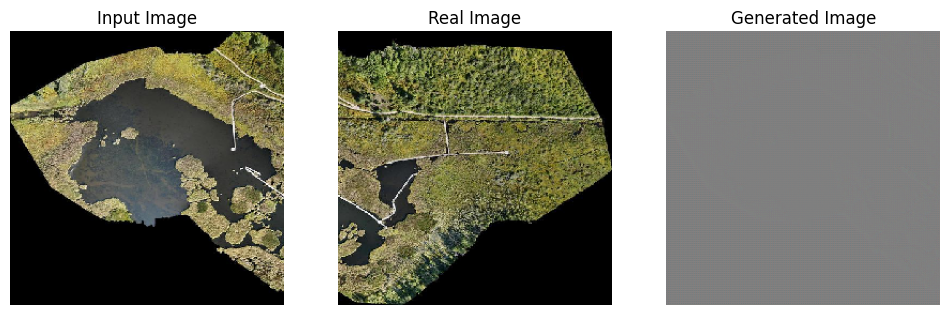

In [37]:
import matplotlib.pyplot as plt

# Generate the output image
generated_image = generator(input_image, training=False)

# Plot the images
plt.figure(figsize=(12, 6))

# Input image
plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow((input_image[0] + 1) / 2)
plt.axis('off')

# Real image
plt.subplot(1, 3, 2)
plt.title("Real Image")
plt.imshow((real_image[0] + 1) / 2)
plt.axis('off')

# Generated image
plt.subplot(1, 3, 3)
plt.title("Generated Image")
plt.imshow((generated_image[0] + 1) / 2)
plt.axis('off')

plt.show()


In [38]:
from tensorflow.keras.preprocessing.image import save_img

# Save the generated image
save_img('generated_image.jpg', (generated_image[0] + 1) * 127.5)


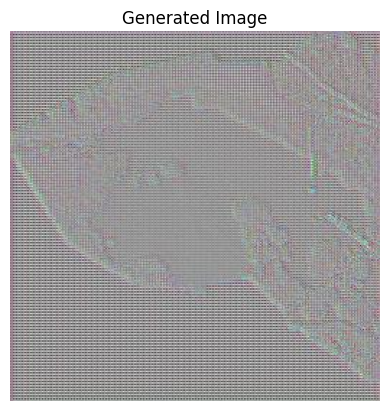

In [39]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

# Path to the generated image file
generated_image_path = 'generated_image.jpg'  # Replace with the actual filename

# Load the image
generated_image = load_img(generated_image_path)

# Display the image
plt.imshow(generated_image)
plt.axis('off')
plt.title('Generated Image')
plt.show()


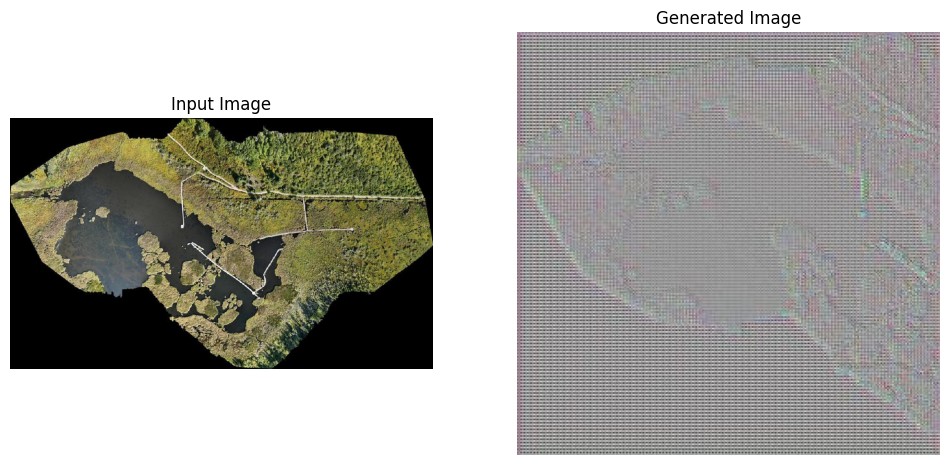

In [41]:
# Load the input image (the one you provided)
input_image_path = '68c065c8e43b2bcaa9829062.png'  # replace with your input image path
input_image = load_img(input_image_path)

# Display both images side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Original Image
axs[0].imshow(input_image)
axs[0].axis('off')
axs[0].set_title('Input Image')

# Generated Image
axs[1].imshow(generated_image)
axs[1].axis('off')
axs[1].set_title('Generated Image')

plt.show()


In [42]:
generated_image.save('generated_output.jpg')
